In [1]:
from torchvision import transforms
import torch

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import CIFAR10

from models.model_final import VisionTransformer, CONFIGS

In [ ]:
config = CONFIGS["ViT-Ours_Final"]

model = VisionTransformer(config, num_classes=10, vis=True)
checkpoint_path = "/home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_3_checkpoint.bin"  
state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件
model.load_state_dict(state_dict)  # 加载模型参数
print(f"Loaded fine-tuned model from {checkpoint_path}")
model.eval()

Loaded fine-tuned model from /home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_3_checkpoint.bin


/tmp/ipykernel_1650678/3051229643.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件


VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNet_2(
        (block0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (block1): Sequential(
          (0): Residual(
            (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
            (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Residual(
            (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): C

Files already downloaded and verified


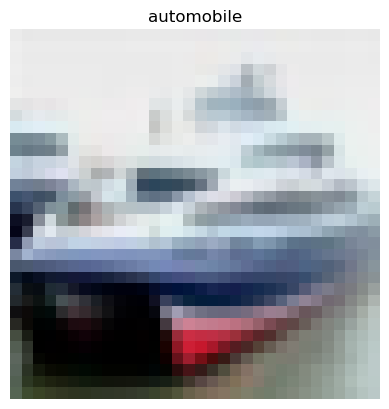

torch.Size([3, 32, 32])


In [ ]:
raw_dataset = CIFAR10(root='./data', train=False, download=True)
classes = raw_dataset.classes

transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

image_idx = 1

x = transform(raw_dataset[image_idx][0])

img = x.permute(1, 2, 0)  # 将 CHW 转换为 HWC

img = img * 0.5 + 0.5  # 逆归一化（从 [-1, 1] 到 [0, 1]）

plt.title(classes[image_idx])
plt.imshow(img)
plt.axis("off")
plt.show()

print(x.shape)

In [4]:
logits, att_mat_orig = model(x.unsqueeze(0))

In [5]:
# Copyright 2022 Google LLC.
# SPDX-License-Identifier: Apache-2.0
# Author: Maithra Raghu <maithra@google.com>
import numpy as np

def compute_distance_matrix(patch_size, num_patches, length):
  """Helper function to compute distance matrix."""

  distance_matrix = np.zeros((num_patches, num_patches))

  for i in range(num_patches):
    for j in range(num_patches):
      if i == j: # zero distance
        continue

      xi, yi = (int(i/length)), (i % length)
      xj, yj = (int(j/length)), (j % length)

      distance_matrix[i, j] = patch_size*np.linalg.norm([xi - xj, yi - yj])
  
  return distance_matrix



def compute_mean_attention_dist(patch_size, attention_weights):
  num_patches = attention_weights.shape[-1]
  length = int(np.sqrt(num_patches))
  assert (length**2 == num_patches), ("Num patches is not perfect square")

  distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
  h, w = distance_matrix.shape

  distance_matrix = distance_matrix.reshape((1, 1, h, w))
  attention_weights = attention_weights.detach().numpy()
  mean_distances = attention_weights * distance_matrix
  mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
  mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokes

  return mean_distances

In [6]:
print(len(att_mat_orig))

8


In [7]:
attn_weights = att_mat_orig[0][0]
print(attn_weights[:, 1:, 1:].shape)

torch.Size([12, 64, 64])


In [8]:
compute_mean_attention_dist(1, attn_weights[:, 1:, 1:])

array([[3.67558477, 3.88734893, 4.27190856, 4.22941332, 3.47143009,
        3.75403964, 3.93782797, 3.15211161, 3.84492486, 3.49154965,
        3.58215233, 4.0715237 ]])